# Is there a Pet waiting?
In this notebook I will use transfer learning to train a classifier
which classifies if there is a pet present on a cctv camera.
RESNET 18 will be use for this project

In [21]:
import torch
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
import torchvision.transforms as tfs
from torchvision.utils import make_grid
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

In [22]:
# Define hyperparameters

BATCH_SIZE = 8
LR = 0.025
EPOCHS = 5
device = "cuda"

In [23]:
# Prepare the model for transfer learning
model = resnet18(pretrained=True)

for parameters in model.parameters():
    parameters.requires_grad = False

last_layer_shape = model.fc.in_features

model.fc = nn.Linear(last_layer_shape, 2)
model = model.to(device)

In [24]:
# Check the model is correctly initialized
# summary(model,input_size=(1,3,224,224))

In [25]:
# Create transforms

# general_transforms = tfs.Compose([
#     tfs.Resize((224,224)),
#     tfs.ToTensor()
#     ])

train_transforms = tfs.Compose([
    tfs.Resize((224,224)),
    tfs.ToTensor(),
    tfs.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    tfs.RandomPosterize(bits=2,p=0.25),
    tfs.RandomAdjustSharpness(sharpness_factor=2,p=0.5),
    tfs.RandomAutocontrast()
])

test_val_transforms = tfs.Compose([
    tfs.Resize((224,224)),
    tfs.ToTensor(),
    tfs.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [26]:
# Load the dataset and create dataloaders
all_datasets = ImageFolder("./data")
dataset_len = len(all_datasets)
# train, validation, test = random_split(all_datasets, [int(dataset_len*0.75),int(dataset_len*0.125),int(dataset_len*0.125+2)])
train, validation, test = random_split(all_datasets, [int(dataset_len*0.75),int(dataset_len*0.125),int(dataset_len*0.125+1)])
print(f"Overall dataset size: {dataset_len}, train: {len(train)}, validation: {len(validation)}, test: {len(test)}")

train.dataset.transform = train_transforms
validation.dataset.transform = test_val_transforms
test.dataset.transform = test_val_transforms


train_loader = DataLoader(train,shuffle=True, batch_size=BATCH_SIZE)
validation_loader = DataLoader(validation, batch_size=BATCH_SIZE)
test_loader = DataLoader(test, batch_size=BATCH_SIZE)


Overall dataset size: 12521, train: 9390, validation: 1565, test: 1566


In [27]:
# Inspect the dataset
# import matplotlib.pyplot as plt


# data = next(iter(train_loader))[0]
# data = make_grid(data)


# plt.imshow(data.permute(1,2,0).numpy())
    
# plt.show()

In [28]:
# Define the Loss function and optimizer
optimizer = torch.optim.SGD(model.parameters(),lr= LR)
loss_fn = torch.nn.CrossEntropyLoss()

## Training and Validation loops

In [29]:
train_losses = []
epoch_train_losses = []
train_correct_epoch = []
train_correct_epoch_perc = []


validation_losses = []
epoch_val_losses = []

for epoch in range(EPOCHS):
    running_epoch_loss = None
    running_correct = 0
    model.train()
    for batch in train_loader:
        x,y = batch
        x = x.to(device)
        y = y.to(device)
        
        # 1. Get the prediction
        pred = model(x)
        
        # 2. Compute the loss
        loss = loss_fn(pred,y)
        
        # 3. Zerout the gradients
        optimizer.zero_grad()
        
        # 4. Compute new gradients and acumulate them
        loss.backward()
        
        # 5. Perform a optimization step
        optimizer.step()
        
        # 3. Get num correct
        _correct = (torch.argmax(pred, dim=1) == y).sum()
        running_correct += _correct.detach()
        
        # Log metrics
        loss_detached = loss.detach()
        
        train_losses.append(loss_detached.cpu())
        
        if running_epoch_loss is not None:
            running_epoch_loss = (running_epoch_loss + loss_detached) / 2.0
        else:
            running_epoch_loss = loss_detached
            
        print(f"Training | EPOCH: {epoch+1} | Average Loss: {running_epoch_loss:.4f} | Current Mini-batch loss: {loss_detached:.4f}")
    
    epoch_train_losses.append(running_epoch_loss)
    train_correct_epoch.append(running_correct.cpu())
    train_correct_epoch_perc.append(running_correct.cpu()/len(train))
    
    running_epoch_loss = None
    model.eval()
    for batch in validation_loader:
        x,y = batch
        x = x.to(device)
        y = y.to(device)
        
        # 1. Get the prediction
        with torch.no_grad():
            pred = model(x)
            
            # 2. Compute the loss
            loss = loss_fn(pred,y)
        
        # Log metrics
        loss_detached = loss.detach()
        
        validation_losses.append(loss_detached.cpu())
        
        if running_epoch_loss is not None:
            running_epoch_loss = (running_epoch_loss + loss_detached) / 2.0
        else:
            running_epoch_loss = loss_detached
            
        print(f"Validation | EPOCH: {epoch+1} | Average Loss: {running_epoch_loss:.4f} | Current Mini-batch loss: {loss_detached:.4f}")
        
    epoch_val_losses.append(running_epoch_loss)   
            



Training | EPOCH: 1 | Average Loss: 0.8663 | Current Mini-batch loss: 0.8663
Training | EPOCH: 1 | Average Loss: 0.4332 | Current Mini-batch loss: 0.0001
Training | EPOCH: 1 | Average Loss: 1.0033 | Current Mini-batch loss: 1.5734
Training | EPOCH: 1 | Average Loss: 0.7984 | Current Mini-batch loss: 0.5935
Training | EPOCH: 1 | Average Loss: 0.5063 | Current Mini-batch loss: 0.2143
Training | EPOCH: 1 | Average Loss: 0.4602 | Current Mini-batch loss: 0.4140
Training | EPOCH: 1 | Average Loss: 0.5275 | Current Mini-batch loss: 0.5948
Training | EPOCH: 1 | Average Loss: 0.5610 | Current Mini-batch loss: 0.5945
Training | EPOCH: 1 | Average Loss: 0.3449 | Current Mini-batch loss: 0.1287
Training | EPOCH: 1 | Average Loss: 0.2577 | Current Mini-batch loss: 0.1704
Training | EPOCH: 1 | Average Loss: 0.3225 | Current Mini-batch loss: 0.3873
Training | EPOCH: 1 | Average Loss: 0.8896 | Current Mini-batch loss: 1.4567
Training | EPOCH: 1 | Average Loss: 0.4448 | Current Mini-batch loss: 0.0000

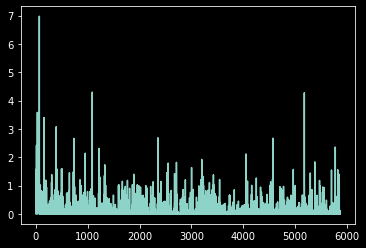

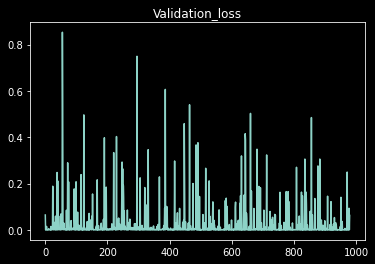

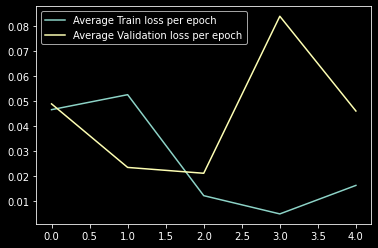

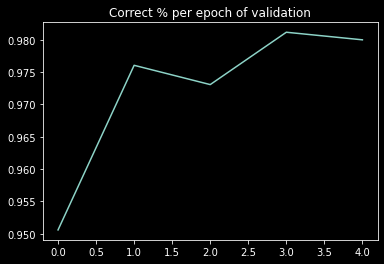

In [30]:
# Visualize the metrics
plt.plot(train_losses)
plt.show()  

plt.plot(validation_losses)
plt.title("Validation_loss")
plt.show()

plt.plot([_.cpu() for _ in epoch_train_losses],label="Average Train loss per epoch")
plt.plot([_.cpu() for _ in epoch_val_losses],label="Average Validation loss per epoch")
plt.legend()
plt.show()

plt.plot(train_correct_epoch_perc)
plt.title("Correct % per epoch of validation")
plt.show()

## Test loop

In [31]:
test_losses = []
avg_loss = None

correct = 0

model.eval()

for batch in test_loader:
    x,y = batch
    x = x.to(device)
    y = y.to(device)
    
    # 1. Get the prediction
    with torch.no_grad():
        pred = model(x)
    
        # 2. Compute the loss
        loss = loss_fn(pred,y)
    
    # 3. Get num correct
    _correct = (torch.argmax(pred, dim=1) == y).sum()
    correct += _correct.detach()
    # Log metrics
    loss_detached = loss.detach()
    
    test_losses.append(loss_detached.cpu())
    
    if avg_loss is not None:
        avg_loss = (avg_loss + loss_detached) / 2.0
    else:
        avg_loss = loss_detached
        
    print(f"Testing | Average Loss: {avg_loss:.4f} | Current Mini-batch loss: {loss_detached:.4f}")

Testing | Average Loss: 0.0001 | Current Mini-batch loss: 0.0001
Testing | Average Loss: 0.0002 | Current Mini-batch loss: 0.0002
Testing | Average Loss: 0.0001 | Current Mini-batch loss: 0.0000
Testing | Average Loss: 0.0004 | Current Mini-batch loss: 0.0006
Testing | Average Loss: 0.0002 | Current Mini-batch loss: 0.0000
Testing | Average Loss: 0.0004 | Current Mini-batch loss: 0.0007
Testing | Average Loss: 0.0004 | Current Mini-batch loss: 0.0003
Testing | Average Loss: 0.0015 | Current Mini-batch loss: 0.0027
Testing | Average Loss: 0.0008 | Current Mini-batch loss: 0.0001
Testing | Average Loss: 0.0010 | Current Mini-batch loss: 0.0012
Testing | Average Loss: 0.0005 | Current Mini-batch loss: 0.0000
Testing | Average Loss: 0.0003 | Current Mini-batch loss: 0.0002
Testing | Average Loss: 0.0002 | Current Mini-batch loss: 0.0001
Testing | Average Loss: 0.2236 | Current Mini-batch loss: 0.4469
Testing | Average Loss: 0.1118 | Current Mini-batch loss: 0.0001
Testing | Average Loss: 0

In [32]:
print(f"Testing | Average Loss: {avg_loss} | Correct {correct}/{len(test)} or {(correct/len(test))*100}%")
last_average_loss = epoch_train_losses[-1].item()

print(f"Difference in Train loss and Test loss: {abs(avg_loss -last_average_loss)}")

Testing | Average Loss: 0.0023826146498322487 | Correct 1544/1566 or 98.59513854980469%
Difference in Train loss and Test loss: 0.013988050632178783


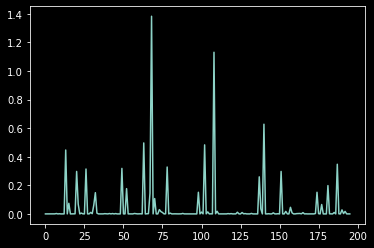

In [33]:
plt.plot(test_losses)
plt.show()

In [34]:
torch.save(model,"./models/model5-5_SGD_98-6_5epochs_025LR_8BS.pth")